# Analysis of `resGIF` fits

`resGIF`, a `GIF` subclass with a time-dependent current fitted to DRN SOM cells.

## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

In [2]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

## Load models

The model we're using here is the newly-implemented (as of 2019.04.02) `resGIF`, a subclass of `GIF` with an added time-dependent current $I_w(t) = g_w w(t)$.

`resGIF` dynamics are defined as $$C \frac{dV}{dt} = -g_l (V(t) - E_l) + g_w w(t) - I_{adapt}(t) + I_{input}(t), $$ where $$ \tau_w \frac{dw}{dt} = V(t) - E_w - w(t).$$
Coefficients are estimated by OLS given values for $\tau_w$ (line search on [1.0, 300.0]ms) and $E_w$ (fixed at -70mV). Points <-65mV not used for fitting.

We expect that for $g_w > 0$ $I_w(t)$ has a high-pass filtering effect, and vice-versa for $g_w < 0$. Since SOM cells with $I_A$ vs. $I_T + K_{slow}$ should have extra low-pass vs. high-pass components to their membrane filters, the sign of $g_w$ should allow to differentiate between potentially interesting SOM types.

Note that because $E_w$ is fixed, changing $g_w$ also adjusts the resting membrane potential. However, this should be compensated by $E_l$, which is left free.

In [3]:
DATA_PATH = os.path.join('data', 'models', 'GABA')
with open(os.path.join(DATA_PATH, 'gaba_resgifs.mod'), 'rb') as f:
    resGIFs = pickle.load(f)
    f.close()

## Inspect models

Extract model parameters related to resonant current $w$.

In [4]:
gwopt_data = np.array([mod.gw for mod in resGIFs])
gwest_data = np.array([mod.fit_all_gw for mod in resGIFs]).T
tauwopt_data = np.array([mod.tau_w for mod in resGIFs]).T
varex_data = np.array([mod.fit_all_r2 for mod in resGIFs]).T
tauw_data = np.array([mod.tau_w_all for mod in resGIFs]).T

### Inspect $\tau_w$ estimates

$\tau_w$ is estimated by picking the value of $\tau_w$ at which $R^2$ **on dV** is minimized. (Simulation methods for `resGIF` not implemented yet, so haven't checked $R^2$ on $V$.)

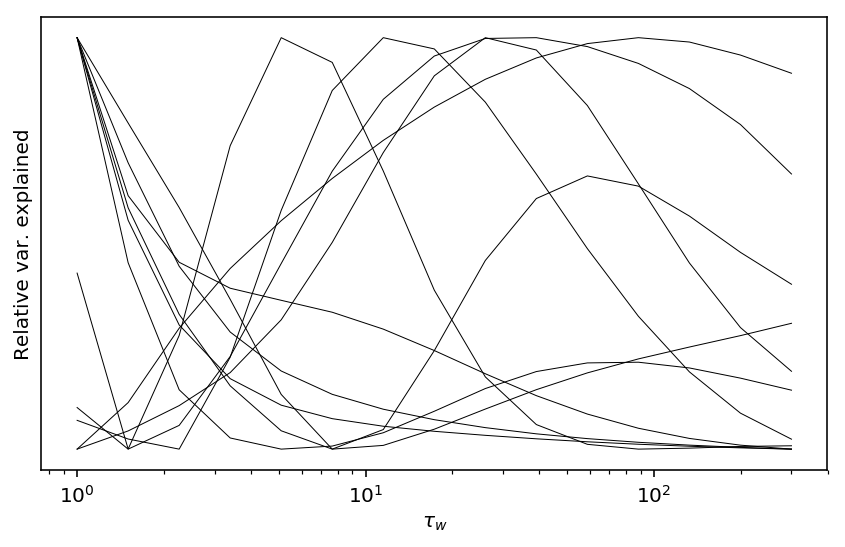

In [5]:
plt.figure()

plt.subplot(111)
plt.semilogx(
    tauw_data, 
    (varex_data - varex_data.min(axis = 0))
        /np.max(varex_data - varex_data.min(axis = 0), axis = 0), 
    'k-', lw = 0.5
)
plt.yticks([])
plt.ylabel('Relative var. explained')
plt.xlabel(r'$\tau_w$')

plt.tight_layout()

plt.show()

A first look at the data shows that for many cells there are two local maxima in the var. explained. Resonance at very high frequencies (e.g., >500Hz, corresponding to $\tau_w < 5$ms) probably means something very different than resonance at slower frequencies.

Going forward, we'll *try* restricting $\tau_w \geq 3.0$ms. 

In [6]:
min_tauw = 3. # Set a lower bound for acceptable tau_w
start_ind = np.argmin(np.abs(tauw_data[:, 0] - 3.))

# Instantiate lists to hold output.
restricted_tauopt_data = []
restricted_gwopt_data = []

# Loop over extracted parameters from each model.
for i in range(varex_data.shape[1]):
    restricted_tauopt_data.append(
        tauw_data[start_ind + np.argmax(varex_data[start_ind:, i], axis = 0), i]
    )
    restricted_gwopt_data.append(
        gwest_data[start_ind + np.argmax(varex_data[start_ind:, i], axis = 0), i]
    )

Make a summary figure.

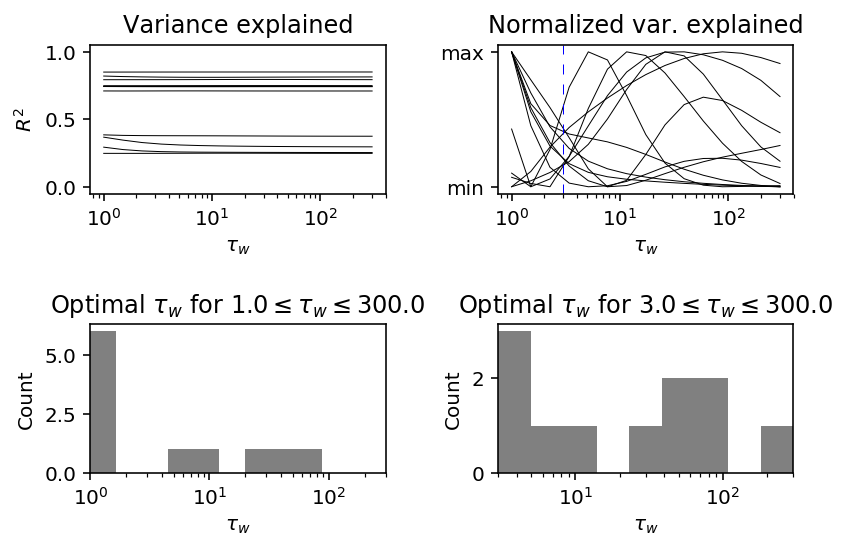

In [7]:
plt.figure(figsize = (6, 4))

varex_ax = plt.subplot(221)
plt.title('Variance explained')
plt.semilogx(tauw_data, varex_data, 'k-', lw = 0.5)
plt.ylim(-0.05, 1.05)
plt.ylabel('$R^2$')
plt.xlabel(r'$\tau_w$')

relvarex_ax = plt.subplot(222)
plt.title('Normalized var. explained')
plt.semilogx(
    tauw_data, 
    (varex_data - np.min(varex_data, axis = 0))
        /np.max((varex_data - np.min(varex_data, axis = 0)), axis = 0),
    'k-', lw = 0.5
)
plt.axvline(min_tauw, color = 'blue', lw = 0.5, ls = '--', dashes = (10, 10))
plt.yticks([0, 1], ['min', 'max'])
plt.xlabel(r'$\tau_w$')

gw_ax = plt.subplot(223)
plt.title(r'Optimal $\tau_w \mathrm{\ for\ } 1.0 \leq \tau_w \leq 300.0 $')
plt.xscale('log')
plt.hist(
    tauwopt_data,
    bins = np.logspace(np.log2(1.), np.log2(np.max(tauwopt_data)), 10, base = 2),
    color = 'gray'
)
plt.xlim(1., 300.)
plt.ylabel('Count')
plt.xlabel(r'$\tau_w$')

gwopt_ax = plt.subplot(224)
plt.title(r'Optimal $\tau_w \mathrm{{\ for\ }} {} \leq \tau_w \leq 300.0 $'.format(min_tauw))
plt.xscale('log')
plt.hist(
    restricted_tauopt_data, 
    bins = np.logspace(np.log2(3.), np.log2(np.max(restricted_tauopt_data)), 10, base = 2),
    color = 'gray'
)
plt.xlim(3., 300.)
plt.ylabel('Count')
plt.xlabel(r'$\tau_w$')


plt.tight_layout()

plt.show()

Notes:
- Variance explained on $\frac{dV}{dt}$ doesn't depend very obviously on choice of $\tau_w$.
    - This is pretty similar to what I see when estimating $\tau_h$ for $I_A$. Seems like $R^2$ on $dV/dt$ is mainly determined by the amount of noise in the recording.
- Two local maxima in $R^2$ for many cells.
- Global maximum is at the lower bound of $\tau_w$ values tried for many cells.
- If we restrict our analysis to $\tau_w \geq 3.0$ms (vertical blue line in upper right plot) we get sensible, non-boundary values of $\tau_w$ for many/most cells.

### Inspect $g_w$ estimates

...Actually, we'll mainly look at $\frac{g_w}{g_l}$ since this is more functionally-relevant.

In [8]:
gwopt_ratio_data = [gwopt/mod.gl for gwopt, mod in zip(gwopt_data, resGIFs)]
restricted_gwopt_ratio_data = [gwopt/mod.gl for gwopt, mod in zip(restricted_gwopt_data, resGIFs)]

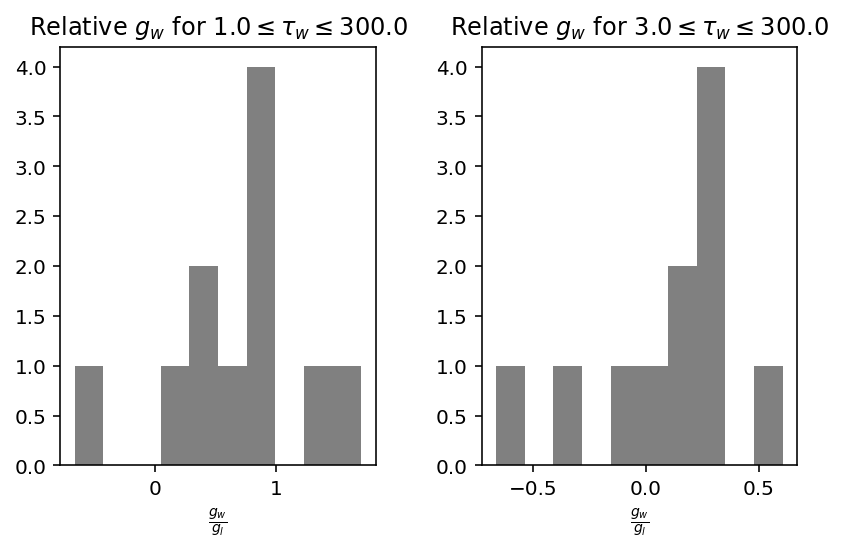

In [9]:
plt.figure()

plt.subplot(121)
plt.title(r'Relative $g_w \mathrm{\ for\ } 1.0 \leq \tau_w \leq 300.0 $')
plt.hist(gwopt_ratio_data, color = 'gray')
plt.xlabel(r'$\frac{g_w}{g_l}$')

plt.subplot(122)
plt.title(r'Relative $g_w \mathrm{\ for\ } 3.0 \leq \tau_w \leq 300.0 $')
plt.hist(restricted_gwopt_ratio_data, color = 'gray')
plt.xlabel(r'$\frac{g_w}{g_l}$')

plt.tight_layout()
plt.show()

$g_w < g_l$ for the most part, indicating that the low-pass component of the membrane filter dominates for most cells.

**TO DO:** Use toy model `toyResMod` to see how obvious/important the effect of $I_w(t)$ is for these values of $g_w, g_l,$ etc.

## Misc. analysis

### Relationship between relative $g_w$ and $\tau_w$

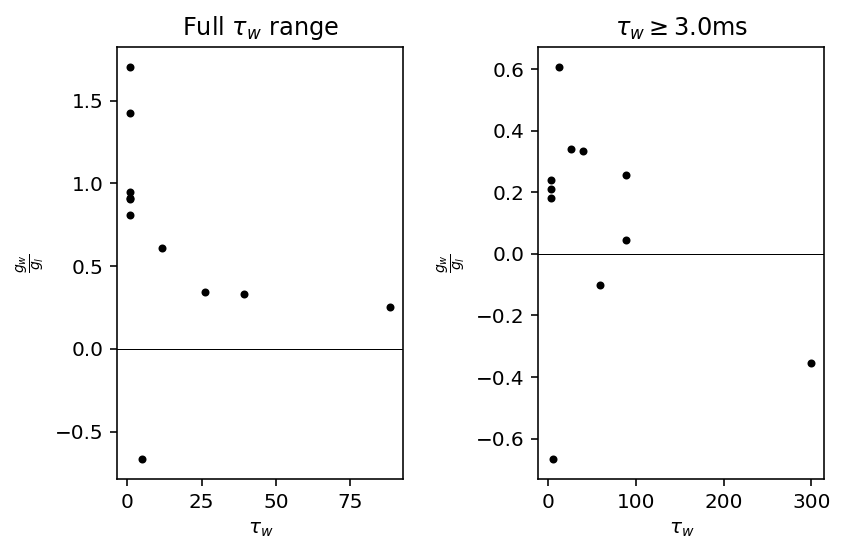

In [10]:
plt.figure()

plt.subplot(121)
plt.title(r'Full $\tau_w$ range')
plt.plot(tauwopt_data, gwopt_ratio_data, 'k.')
plt.axhline(0, color = 'k', lw = 0.5)
plt.ylabel(r'$\frac{g_w}{g_l}$')
plt.xlabel(r'$\tau_w$')

plt.subplot(122)
plt.title(r'$\tau_w \geq 3.0$ms')
plt.plot(restricted_tauopt_data, restricted_gwopt_ratio_data, 'k.')
plt.axhline(0, color = 'k', lw = 0.5)
plt.ylabel(r'$\frac{g_w}{g_l}$')
plt.xlabel(r'$\tau_w$')

plt.tight_layout()
plt.show()

Hard to tell whether there's a relationship between estimated values of $\frac{g_w}{g_l}$ and $\tau_w$ with so few points...

### Estimated $g_l$

In [11]:
gl_data = np.array([mod.gl for mod in resGIFs])
print 'g_l <= 0 in {} cells'.format(np.sum(gl_data <= 0))

g_l <= 0 in 2 cells


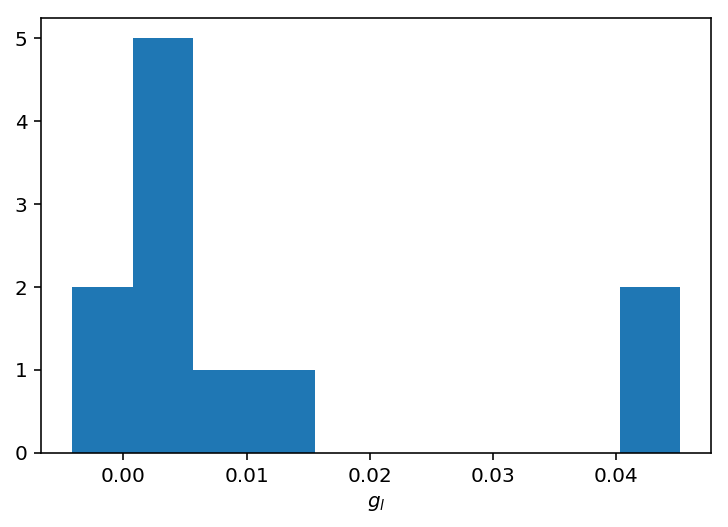

In [12]:
plt.hist(gl_data)
plt.xlabel('$g_l$')
plt.show()

$g_l < 0$ in some cells means there is more work to be done.